In [7]:
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_hiive import SARunner, GARunner, MIMICRunner, RHCRunner

from util.utils import run_experiment_multi_seed, runner_results_to_stats, plot_fitness_iteration, get_optimal_hyperparameters
from util.utils import plot_fitness_vs_hyperparameter, plot_HP_heatmap, plot_fitness_fevals, get_kcolor, get_perf_stats

# switch off the chatter
logging.basicConfig(level=logging.WARNING)


%load_ext autoreload
%autoreload 2

# Fixed random seed for reproducibility on random optimization problems
FIXED_SEED = 42
np.random.seed(FIXED_SEED)
# Random Seeds for reproducibility
RANDOM_SEEDS = [1, 2, 3, 4, 5]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Initialization of the problems
There will be three subproblems per RO problem with increasing difficulty. For *k*-Color, difficulty is increasing as the number of nodes, connections per node increases and k decreases.<br>
We define the subproblems as follows:
1. **Easy**: &emsp;&emsp;&ensp; $n_{nodes} = 20, max_{conn} = 2$
2. **Medium**:&emsp; $n_{nodes} = 30, max_{conn} = 3$
3. **Hard**: &emsp;&emsp;&ensp;$n_{nodes} = 50, max_{conn} = 4$

Note: The number of colors, *k*, depends on the graph structure and is not fixed. The minimum value of *k* for a graph to be *k*-colorable is the chromatic number of the graph, for which we can find a lower bound given by the size of the largest clique in the graph. We will use this lower bound as the initial value of *k* for the *k*-Color problem. Thus, the value of *k* for each subproblem will be: <br>

1. **Easy**: &emsp;&emsp;&ensp; $k = 3$
2. **Medium**:&emsp; $k = 4$
3. **Hard**: &emsp;&emsp;&ensp;$k = 5$

Each problem will be solved using the following algorithms:
1. **Hill Climbing with Random Restarts (RHC)**
2. **Simulated Annealing (SA)**
3. **Genetic Algorithm (GA)**
4. **MIMIC**

For each algorithm, we will run the random optimization algorithm with a set of random seeds to mitigate the effect of lucky and unlucky runs.

In [8]:
problem_easy = MaxKColorGenerator().generate(seed=FIXED_SEED, number_of_nodes=20, max_connections_per_node=2, max_colors=3, maximize=True)
problem_medium = MaxKColorGenerator().generate(seed=FIXED_SEED, number_of_nodes=30, max_connections_per_node=3, max_colors=4, maximize=True)
problem_hard = MaxKColorGenerator().generate(seed=FIXED_SEED, number_of_nodes=50, max_connections_per_node=6, max_colors=4, maximize=True)
problem_extreme = MaxKColorGenerator().generate(seed=FIXED_SEED, number_of_nodes=75, max_connections_per_node=8, max_colors=4, maximize=True)

In [9]:
problem = get_kcolor("hard")
# nx.draw(problem.source_graph,
#         pos=nx.spring_layout(problem.source_graph, seed = FIXED_SEED))
# plt.show()

# # Count the number of vertices in the graph
print(problem.source_graph.number_of_edges())

# # Find the largest Clique in the graph
# # Find all cliques in the graph
all_cliques = list(nx.find_cliques(problem.source_graph))

# Find the largest clique
largest_clique = max(all_cliques, key=len)

print("All cliques:", all_cliques)
print("Largest clique:", largest_clique)

176
All cliques: [[0, 3], [0, 41], [0, 10, 33], [0, 10, 43], [0, 10, 37], [0, 44], [0, 19], [1, 40], [1, 2], [1, 4, 8, 35], [1, 4, 49, 35], [1, 4, 49, 22], [1, 6], [2, 48], [2, 36, 44], [2, 37], [2, 46], [3, 34, 7], [3, 36, 38], [3, 13], [3, 16], [4, 34], [4, 14, 22], [7, 24, 26], [7, 24, 35], [7, 24, 34], [7, 25, 34], [7, 25, 42], [7, 10, 35], [8, 9, 5], [8, 47], [9, 29], [9, 23, 40], [9, 23, 39], [10, 5], [13, 32], [13, 6], [13, 44], [13, 46, 21], [13, 18], [13, 25], [14, 19], [14, 20, 24], [14, 22, 44], [14, 22, 39], [14, 24, 26], [15, 34], [15, 5], [15, 38], [15, 6, 31], [15, 42, 31], [15, 11], [15, 49, 35], [15, 49, 12], [15, 49, 31], [15, 17], [15, 19], [16, 35, 24], [16, 35, 39], [16, 41, 12], [16, 41, 39], [16, 42, 25], [16, 20, 24], [18, 35, 39], [18, 12, 29], [18, 30], [20, 32, 36, 38], [20, 33], [20, 45], [20, 17], [20, 31], [21, 33], [21, 37], [21, 17, 46], [21, 17, 30], [21, 19], [21, 29], [22, 49, 46], [22, 11, 46], [22, 37], [23, 24], [23, 12], [23, 45], [23, 30], [25, 4

# 2. Testing

Experiments: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


<Figure size 640x480 with 0 Axes>

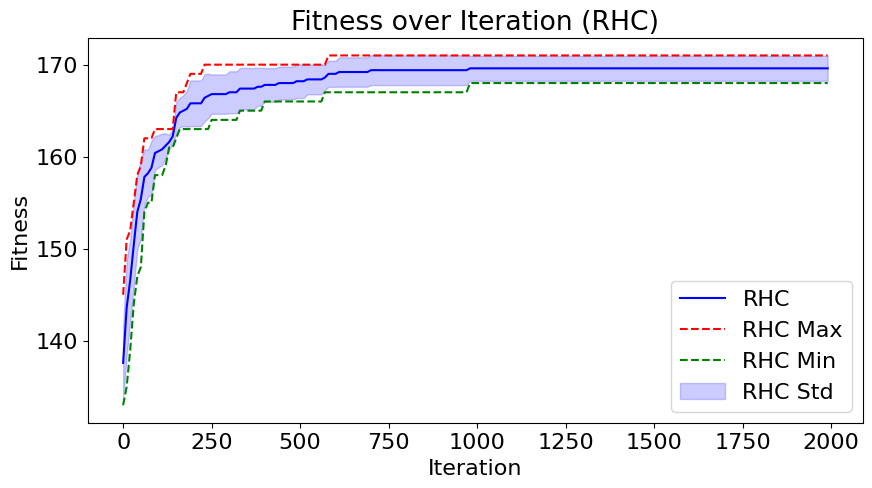

Best Fitness: 169.6
MAX Fitness: 171.0
First feval with best fitness: 1002.2


<Figure size 640x480 with 0 Axes>

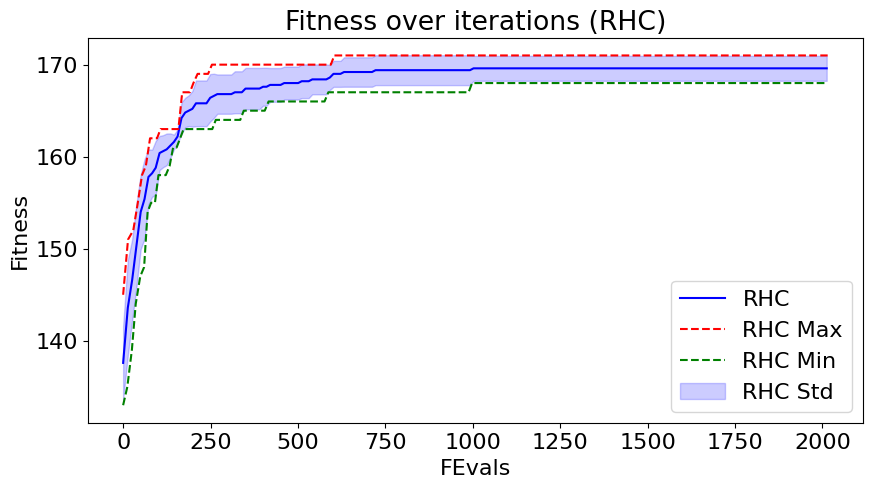

In [4]:
difficulty = "hard"
rhc = RHCRunner(
                problem=get_kcolor(difficulty),
                experiment_name='rhc',
                output_directory=None,
                seed=FIXED_SEED,
                iteration_list= np.arange(0, 2000, 10),
                restart_list=[0],
                max_attempts=2000,
                )

rhc_results = run_experiment_multi_seed(rhc, RANDOM_SEEDS)

rhc_mean, rhc_std, rhc_min, rhc_max = runner_results_to_stats(rhc_results)
plot_fitness_iteration(rhc_mean, rhc_std, rhc_min, rhc_max, "RHC", difficulty)

# plot the mean and std of the fitness with nice plots
print(f'Best Fitness: {rhc_mean["Fitness"].max()}')
print(f'MAX Fitness: {rhc_max["Fitness"].max()}')
# print the first feval with the best fitness
print(f'First feval with best fitness: {rhc_mean["FEvals"].loc[rhc_mean["Fitness"].idxmax()]}')
plot_fitness_fevals(rhc_mean, rhc_std, rhc_min, rhc_max, "RHC", "KCOLOR")

In [13]:
difficulty = "medium"
rhc = RHCRunner(
                problem=get_kcolor(difficulty),
                experiment_name='rhc',
                output_directory=None,
                seed=FIXED_SEED,
                iteration_list= np.arange(0, 2000, 25),
                restart_list=[20],
                max_attempts=250,
                )

rhc_results = rhc.run()
rhc_results = [rhc_results]

rhc_mean, rhc_std, rhc_min, rhc_max = runner_results_to_stats(rhc_results)

Experiments: 100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


Best Fitness: 60.0
MAX Fitness: 60.0
Number of fitness evaluations: 8834
First feval with best fitness: 161.0
Time execution: 8.95580867100216


<Figure size 640x480 with 0 Axes>

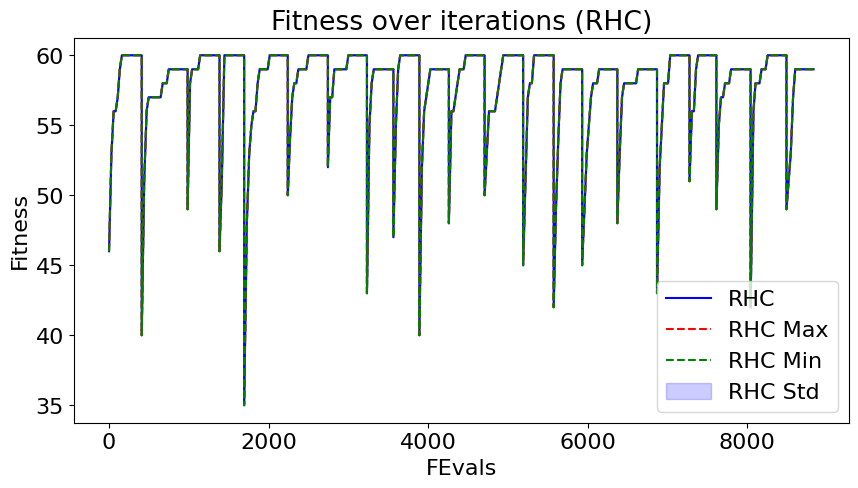

In [14]:
# plot the mean and std of the fitness with nice plots
print(f'Best Fitness: {rhc_mean["Fitness"].max()}')
print(f'MAX Fitness: {rhc_max["Fitness"].max()}')
print(f"Number of fitness evaluations: {rhc_max['FEvals'].max()}")
# print the first feval with the best fitness
print(f'First feval with best fitness: {rhc_mean["FEvals"].loc[rhc_mean["Fitness"].idxmax()]}')
print(f'Time execution: {rhc_max["Time"].max()}')
plot_fitness_fevals(rhc_mean, rhc_std, rhc_min, rhc_max, "RHC", "KCOLOR")

Experiments: 100%|██████████| 1/1 [00:25<00:00, 25.78s/it]


Best Fitness: 78.0
MAX Fitness: 78.0
Fevals: 11165.0
Time: 25.755782901000202


<Figure size 640x480 with 0 Axes>

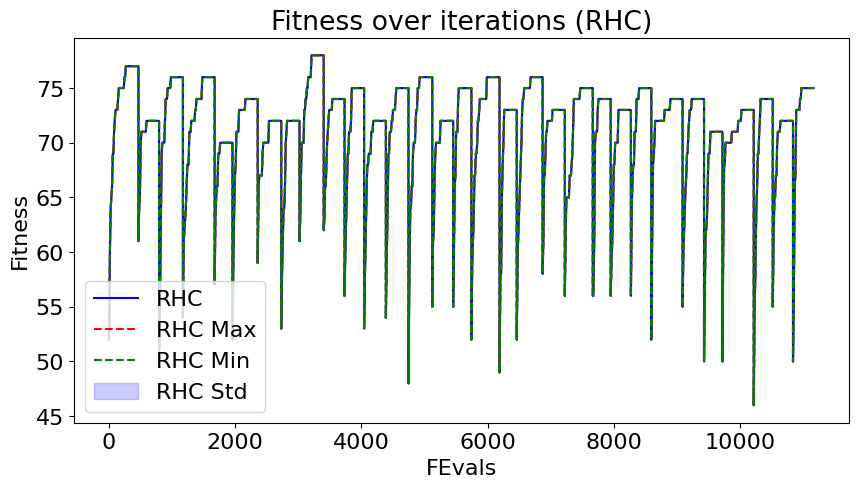

In [68]:

# plot the mean and std of the fitness with nice plots
print(f'Best Fitness: {rhc_mean["Fitness"].max()}')
print(f'MAX Fitness: {rhc_max["Fitness"].max()}')
print(f'Fevals: {rhc_mean["FEvals"].max()}')
print(f'Time: {rhc_mean["Time"].max()}')
plot_fitness_fevals(rhc_mean, rhc_std, rhc_min, rhc_max, "RHC", "KCOLOR")

In [48]:
best_it = rhc_mean.iloc[rhc_mean['Fitness'].idxmax()]
best_it

Iteration                                                        740
Fitness                                                        251.4
FEvals                                                         635.4
Time                                                        1.598513
State              [1, 3, 0, 3, 1, 0, 0, 2, 2, 0, 3, 2, 1, 2, 1, ...
Restarts                                                           0
max_iters                                                       1990
current_restart                                                    0
Name: 74, dtype: object

In [53]:
def show_k_color(problem, df_mean):
    best_it = df_mean.iloc[df_mean['Fitness'].idxmax()]
    color_indexes = literal_eval(best_it['State'])
    ordered_state = [color_indexes[n] for n in problem.source_graph.nodes]
    print(ordered_state)

    colors = ['lightcoral', 'lightgreen', 'lightblue', 'lightyellow', 'lightpink', 'lightgrey', 'lightcyan', 'lightseagreen', 'lightsalmon', 'lightsteelblue', 'lightgoldenrodyellow', 'lightseagreen']
    node_color_map = [colors[s] for s in ordered_state]

    nx.draw(problem.source_graph,
            pos=nx.spring_layout(problem.source_graph, seed = FIXED_SEED),
            with_labels=True,
            node_color=node_color_map)
    plt.show()

[1, 3, 0, 2, 3, 3, 3, 2, 3, 0, 0, 1, 1, 1, 3, 3, 2, 2, 2, 1, 0, 3, 0, 1, 2, 3, 0, 0, 0, 2, 3, 2, 1, 1, 2, 0, 3, 0, 3, 1, 2, 0, 2, 2, 3, 2, 3, 1, 1, 1]


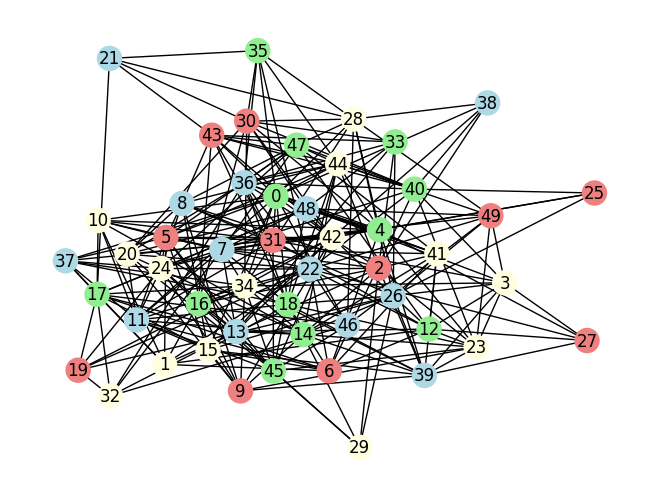

In [54]:
show_k_color(problem, rhc_mean)

# 3. Hyperparameter Tuning

## 3.1 SA

In [ ]:
difficulty = "hard"
sa = SARunner(problem=get_kcolor(difficulty),
              experiment_name='sa',
              output_directory=None, # note: specify an output directory to have results saved to disk "experiments/TSP_SA_HP"
              seed=FIXED_SEED,
              iteration_list=np.arange(0, 2000, 10),
              max_attempts=100,
              temperature_list=[1.0, 3.0, 5.0, 10.0, 20.0],
              decay_list=[mlrose_hiive.ArithDecay, mlrose_hiive.ExpDecay, mlrose_hiive.GeomDecay])

sa_results = run_experiment_multi_seed(sa, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_SA_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(sa_results, f)


Experiments:   0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

Experiments: 100%|██████████| 15/15 [02:52<00:00, 11.49s/it]


In [10]:
import pickle
difficulty = "hard"
with open(f'experiments/KC_SA_HP_{difficulty}.pkl', 'rb') as f:
    sa_results = pickle.load(f)

get_perf_stats(sa_results, 'schedule_init_temp', 'schedule_type')

{'schedule_init_temp': 3.0, 'schedule_type': 'exponential'}
Mean Fitness: 174.8
MAX fitness: 176.0 
FEvals: 2345.2
Time: 6.5136595571995715
      Iteration  Fitness  FEvals      Time                                              State schedule_type  schedule_init_temp  schedule_decay  schedule_min_temp  schedule_current_value Temperature  max_iters  schedule_exp_const
2274        740    176.0    1038  5.572294  [3, 2, 0, 1, 3, 3, 3, 0, 2, 1, 2, 2, 3, 0, 0, ...     geometric                10.0            0.99              0.001                9.615969        10.0       1990                 NaN


In [13]:
sa_hp_mean

,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_decay,schedule_min_temp,schedule_current_value,Temperature,max_iters,schedule_exp_const
0,0,137.6,0.0,0.000251,"[1, 3, 0, 0, 3, 1, 3, 1, 3, 0, 0, 1, 0, 3, 1, ...",arithmetic,1.0,0.0001,0.001,1.000000,1.0,1990,NaN
1,10,143.0,16.0,0.002710,"[1, 3, 0, 0, 0, 1, 3, 3, 3, 0, 0, 1, 0, 3, 1, ...",arithmetic,1.0,0.0001,0.001,1.000000,1.0,1990,NaN
2,20,144.4,32.0,0.005115,"[1, 3, 0, 0, 0, 1, 3, 3, 0, 3, 0, 1, 0, 3, 1, ...",arithmetic,1.0,0.0001,0.001,1.000000,1.0,1990,NaN
3,30,147.6,47.6,0.007797,"[1, 3, 1, 0, 2, 1, 0, 3, 0, 3, 0, 2, 1, 2, 1, ...",arithmetic,1.0,0.0001,0.001,0.999999,1.0,1990,NaN
4,40,147.4,63.0,0.011847,"[1, 3, 1, 0, 2, 2, 0, 3, 0, 3, 0, 2, 1, 2, 1, ...",arithmetic,1.0,0.0001,0.001,0.999999,1.0,1990,NaN
5,50,151.2,77.8,0.015497,"[1, 3, 1, 0, 2, 2, 2, 3, 0, 2, 0, 2, 1, 2, 1, ...",arithmetic,1.0,0.0001,0.001,0.999999,1.0,1990,NaN
6,60,153.6,92.6,0.021452,"[1, 3, 0, 0, 2, 0, 2, 3, 0, 2, 0, 2, 1, 2, 1, ...",arithmetic,1.0,0.0001,0.001,0.999999,1.0,1990,NaN
7,70,153.2,107.2,0.024337,"[1, 3, 0, 0, 2, 0, 2, 3, 0, 2, 0, 2, 1, 3, 1, ...",arithmetic,1.0,0.0001,0.001,0.999999,1.0,1990,NaN
8,80,153.6,122.6,0.028232,"[1, 3, 1, 0, 2, 2, 2, 3, 0, 2, 0, 2, 1, 3, 2, ...",arithmetic,1.0,0.0001,0.001,0.999999,1.0,1990,NaN
9,90,155.4,138.4,0.030869,"[1, 3, 1, 0, 2, 2, 2, 3, 0, 2, 0, 2, 1, 2, 1, ...",arithmetic,1.0,0.0001,0.001,0.999998,1.0,1990,NaN


In [11]:
sa_hp_mean, sa_hp_std, sa_hp_min, sa_hp_max = runner_results_to_stats(sa_results)
sa_optimal_HP = get_optimal_hyperparameters(sa_hp_mean, ['schedule_init_temp', 'schedule_type'])
sa_optimal_HP

{'schedule_init_temp': 3.0, 'schedule_type': 'exponential'}

schedule_type
schedule_init_temp = 1.0 Fitness: 173.6 (+/- 6.44980619863884), Time: 1.0143456645950208
schedule_init_temp = 3.0 Fitness: 173.4 (+/- 6.711184694225007), Time: 2.8250838116015076
schedule_init_temp = 5.0 Fitness: 173.0 (+/- 6.374950980203691), Time: 4.829932281002402
schedule_init_temp = 10.0 Fitness: 174.4 (+/- 7.249827584156742), Time: 6.950426922200132
schedule_init_temp = 20.0 Fitness: 173.2 (+/- 8.182909018191513), Time: 6.897081003600033


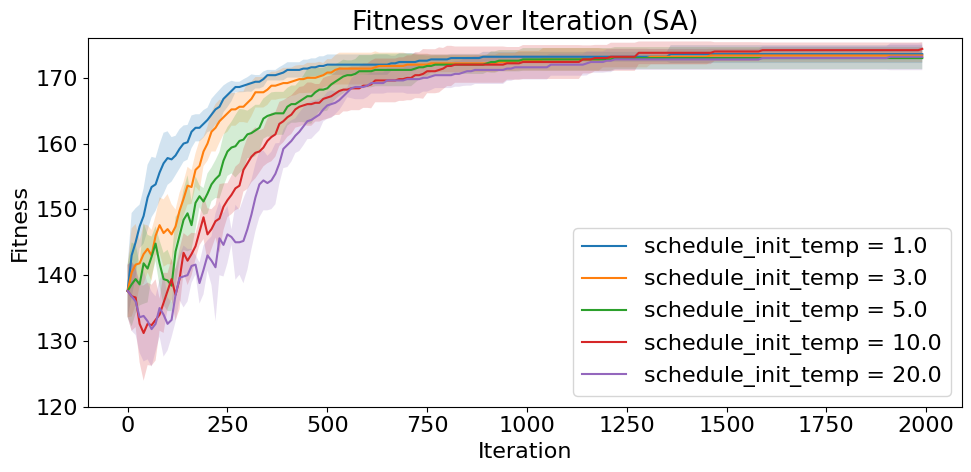

schedule_init_temp
schedule_type = arithmetic Fitness: 142.0 (+/- 9.707728879609277), Time: 8.728846448400873
schedule_type = exponential Fitness: 173.6 (+/- 7.391887445030531), Time: 6.319908849397325
schedule_type = geometric Fitness: 174.4 (+/- 7.249827584156742), Time: 6.950426922200132


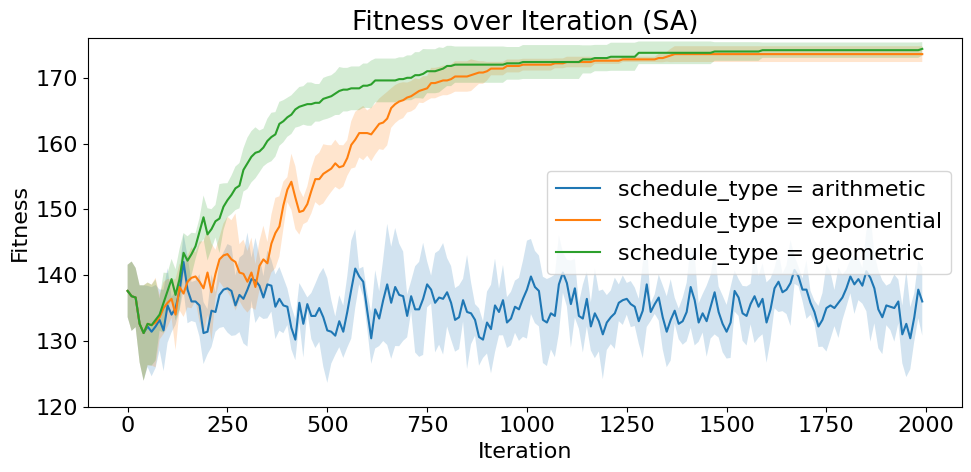

In [40]:
for key in sa_optimal_HP.keys():
    plot_fitness_vs_hyperparameter(sa_hp_mean, sa_hp_std, sa_optimal_HP, key, "SA", "TSP", y_lim=(120,176), show_std=True)

In [45]:
difficulty = "medium"
sa = SARunner(problem=get_kcolor(difficulty),
              experiment_name='sa',
              output_directory=None, # note: specify an output directory to have results saved to disk "experiments/TSP_SA_HP"
              seed=FIXED_SEED,
              iteration_list=np.arange(0, 2000, 10),
              max_attempts=100,
              temperature_list=[1.0, 3.0, 5.0, 10.0, 20.0],
              decay_list=[mlrose_hiive.ArithDecay, mlrose_hiive.ExpDecay, mlrose_hiive.GeomDecay])

sa_results = run_experiment_multi_seed(sa, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_SA_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(sa_results, f)


In [46]:
import pickle
with open(f'experiments/KC_SA_HP_{difficulty}.pkl', 'rb') as f:
    sa_results = pickle.load(f)

get_perf_stats(sa_results, 'schedule_init_temp', 'schedule_type')

{'schedule_init_temp': 1.0, 'schedule_type': 'exponential'}
Mean Fitness: 60.0
MAX fitness: 60.0 
FEvals: 2494.2
Time: 2.066993670602096
     Iteration  Fitness  FEvals     Time                                              State schedule_type  schedule_init_temp  schedule_decay  schedule_min_temp  schedule_current_value Temperature  max_iters  schedule_exp_const
411        110     60.0     169  0.12311  [2, 3, 1, 1, 2, 0, 1, 0, 0, 2, 0, 2, 0, 1, 1, ...     geometric                 1.0            0.99              0.001                0.998763         1.0       1990                 NaN


In [48]:
difficulty = "easy"
sa = SARunner(problem=get_kcolor(difficulty),
              experiment_name='sa',
              output_directory=None, # note: specify an output directory to have results saved to disk "experiments/TSP_SA_HP"
              seed=FIXED_SEED,
              iteration_list=np.arange(0, 2000, 10),
              max_attempts=100,
              temperature_list=[1.0, 3.0, 5.0, 10.0, 20.0],
              decay_list=[mlrose_hiive.ArithDecay, mlrose_hiive.ExpDecay, mlrose_hiive.GeomDecay])

sa_results = run_experiment_multi_seed(sa, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_SA_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(sa_results, f)


In [50]:
import pickle
with open(f'experiments/KC_SA_HP_{difficulty}.pkl', 'rb') as f:
    sa_results = pickle.load(f)

get_perf_stats(sa_results, 'schedule_init_temp', 'schedule_type')

{'schedule_init_temp': 1.0, 'schedule_type': 'exponential'}
Mean Fitness: 26.0
MAX fitness: 26.0 
FEvals: 2477.4
Time: 4.9079801918007435
     Iteration  Fitness  FEvals      Time                                              State schedule_type  schedule_init_temp  schedule_decay  schedule_min_temp  schedule_current_value Temperature  max_iters  schedule_exp_const
204         40     26.0      68  0.060898  [1, 0, 1, 1, 2, 0, 1, 2, 0, 0, 1, 1, 0, 2, 1, ...   exponential                 1.0             NaN              0.001                0.999696         1.0       1990               0.005
404         40     26.0      68  0.078594  [2, 1, 1, 1, 2, 0, 0, 2, 0, 1, 1, 1, 1, 2, 0, ...     geometric                 1.0            0.99              0.001                0.999313         1.0       1990                 NaN


## 3.2 GA

In [36]:
difficulty = "medium"

ga = GARunner(problem=get_kcolor(difficulty),
              experiment_name='tsp_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=FIXED_SEED,
              iteration_list=np.arange(0, 1000, 100),
              max_attempts=50,
              population_sizes=np.arange(200, 700, 100),
              mutation_rates=[0.05, 0.1, 0.15, 0.20, 0.25]
            )

ga_results = run_experiment_multi_seed(ga, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_GA_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(ga_results, f)

Runner 0 seed: 1
Runner 1 seed: 2
Runner 2 seed: 3
Runner 3 seed: 4
Runner 4 seed: 5


In [54]:
difficulty = "hard"
import pickle
with open(f'experiments/KC_GA_HP_{difficulty}.pkl', 'rb') as f:
    ga_results = pickle.load(f)

ga_hp_mean, ga_hp_std, ga_hp_min, ga_hp_max = runner_results_to_stats(ga_results)

ga_optimal_HP = get_optimal_hyperparameters(ga_hp_mean,['Population Size', 'Mutation Rate'])
ga_optimal_HP

{'Population Size': 300, 'Mutation Rate': 0.05}

<Figure size 640x480 with 0 Axes>

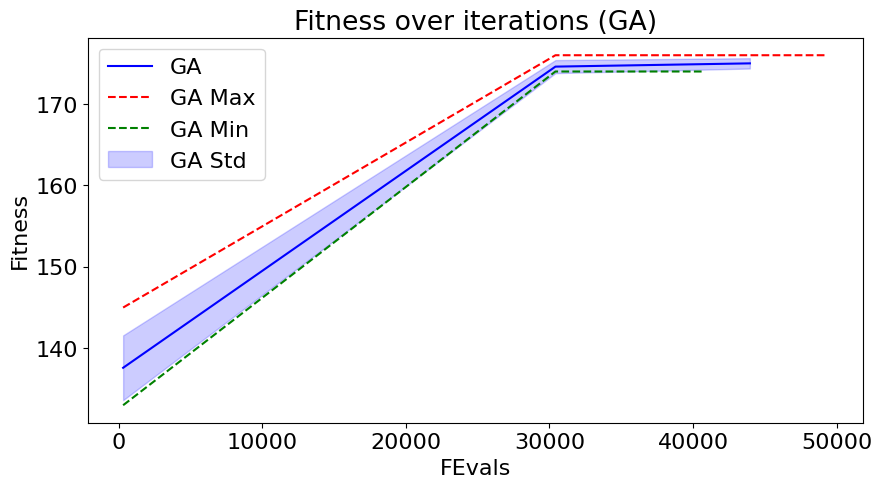

In [55]:
best_mean = ga_hp_mean[(ga_hp_mean['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_mean['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
best_std = ga_hp_std[(ga_hp_mean['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_mean['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
best_min = ga_hp_min[(ga_hp_mean['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_mean['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
best_max = ga_hp_max[(ga_hp_mean['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_mean['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
plot_fitness_fevals(best_mean, best_std, best_min, best_max, "GA", "TSP")

Mutation Rate
Population Size = 200 Fitness: 173.8 (+/- 3.97994974842648), Time: 3.525185270200018
Population Size = 300 Fitness: 175.0 (+/- 3.97994974842648), Time: 8.34575975459884
Population Size = 400 Fitness: 174.2 (+/- 3.97994974842648), Time: 9.923983694400523
Population Size = 500 Fitness: 174.8 (+/- 3.97994974842648), Time: 17.86347647739749
Population Size = 600 Fitness: 174.4 (+/- 3.97994974842648), Time: 14.988391381397378


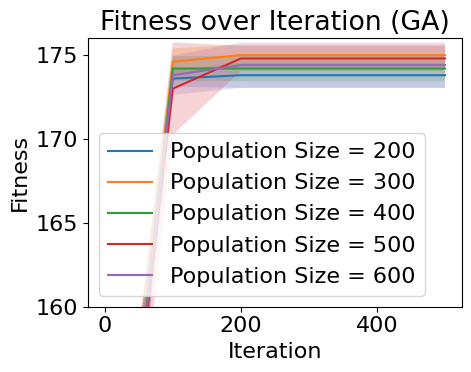

Population Size
Mutation Rate = 0.05 Fitness: 175.0 (+/- 3.97994974842648), Time: 8.34575975459884
Mutation Rate = 0.1 Fitness: 174.0 (+/- 3.97994974842648), Time: 7.0488867354055404
Mutation Rate = 0.15 Fitness: 174.2 (+/- 3.97994974842648), Time: 7.663525399399805
Mutation Rate = 0.2 Fitness: 173.8 (+/- 3.97994974842648), Time: 8.670303794002393


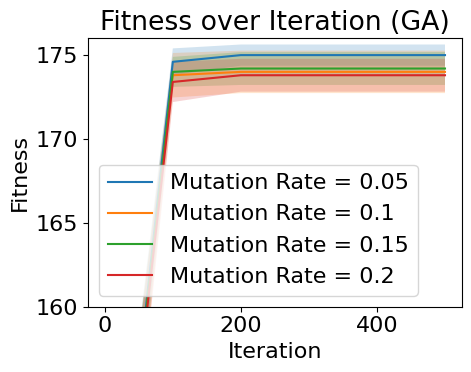

In [71]:
for key in ga_optimal_HP.keys():
    plot_fitness_vs_hyperparameter(ga_hp_mean, ga_hp_std, ga_optimal_HP, key, "GA", "KCOL", y_lim=(160, 176))

In [72]:
best_run = ga_hp_mean[(ga_hp_mean['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_mean['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
best_run_max = ga_hp_max[(ga_hp_max['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_max['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
print(ga_optimal_HP)
print(f'Mean Fitness: {best_run["Fitness"].max()}')
print(f'MAX fitness: {best_run_max["Fitness"].max()} ')
print(f'FEvals: {best_run["FEvals"].max()}')
print(f'Time: {best_run["Time"].max()}')

# select all the runs reaching 176 fitness
best_runs = ga_hp_max[ga_hp_max['Fitness'] == 176]

# select the best run with the lowest number of fevals
best_run = best_runs[best_runs['FEvals'] == best_runs['FEvals'].min()]
best_run


{'Population Size': 300, 'Mutation Rate': 0.05}
Mean Fitness: 175.0
MAX fitness: 176.0 
FEvals: 43961.0
Time: 8.34575975459884


,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
25,100,176.0,30417,7.986454,"[1, 1, 3, 2, 2, 0, 3, 1, 3, 1, 3, 3, 0, 0, 1, ...",300,0.05,500


In [102]:
difficulty = "easy"

ga = GARunner(problem=get_kcolor(difficulty),
              experiment_name='tsp_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=FIXED_SEED,
              iteration_list=np.arange(0, 600, 100),
              max_attempts=50,
              population_sizes=np.arange(200, 700, 100),
              mutation_rates=[0.05, 0.1, 0.15, 0.20]
            )

ga_results = run_experiment_multi_seed(ga, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_GA_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(ga_results, f)

In [73]:
difficulty = "easy"
import pickle
with open(f'experiments/KC_GA_HP_{difficulty}.pkl', 'rb') as f:
    ga_results = pickle.load(f)

get_perf_stats(ga_results, "Population Size", "Mutation Rate")

{'Population Size': 200, 'Mutation Rate': 0.05}
Mean Fitness: 26.0
MAX fitness: 26.0 
FEvals: 13027.2
Time: 0.6940459343983093
    Iteration  Fitness  FEvals      Time                                              State  Population Size  Mutation Rate  max_iters
19        100     26.0   13068  0.955071  [2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, ...              200            0.2        500
20        200     26.0   13068  0.955071  [2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, ...              200            0.2        500
21        300     26.0   13068  0.955071  [2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, ...              200            0.2        500
22        400     26.0   13068  0.955071  [2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, ...              200            0.2        500
23        500     26.0   13068  0.955071  [2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, ...              200            0.2        500


In [105]:
difficulty = "medium"

ga = GARunner(problem=get_kcolor(difficulty),
              experiment_name='tsp_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=FIXED_SEED,
              iteration_list=np.arange(0, 600, 100),
              max_attempts=50,
              population_sizes=np.arange(200, 700, 100),
              mutation_rates=[0.05, 0.1, 0.15, 0.20]
            )

ga_results = run_experiment_multi_seed(ga, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_GA_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(ga_results, f)

In [74]:
difficulty = "medium"
import pickle
with open(f'experiments/KC_GA_HP_{difficulty}.pkl', 'rb') as f:
    ga_results = pickle.load(f)

get_perf_stats(ga_results, "Population Size", "Mutation Rate")

{'Population Size': 200, 'Mutation Rate': 0.05}
Mean Fitness: 60.0
MAX fitness: 60.0 
FEvals: 16647.6
Time: 1.1030312980001327
   Iteration  Fitness  FEvals      Time                                              State  Population Size  Mutation Rate  max_iters
1        100     60.0   18497  1.386377  [2, 0, 1, 1, 3, 3, 3, 3, 2, 2, 1, 0, 2, 0, 1, ...              200           0.05        500
2        200     60.0   18497  1.386377  [2, 0, 1, 1, 3, 3, 3, 3, 2, 2, 1, 0, 2, 0, 1, ...              200           0.05        500
3        300     60.0   18497  1.386377  [2, 0, 1, 1, 3, 3, 3, 3, 2, 2, 1, 0, 2, 0, 1, ...              200           0.05        500
4        400     60.0   18497  1.386377  [2, 0, 1, 1, 3, 3, 3, 3, 2, 2, 1, 0, 2, 0, 1, ...              200           0.05        500
5        500     60.0   18497  1.386377  [2, 0, 1, 1, 3, 3, 3, 3, 2, 2, 1, 0, 2, 0, 1, ...              200           0.05        500


In [107]:
difficulty = "hard"

ga = GARunner(problem=get_kcolor(difficulty),
              experiment_name='tsp_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=FIXED_SEED,
              iteration_list=np.arange(0, 600, 100),
              max_attempts=50,
              population_sizes=np.arange(200, 700, 100),
              mutation_rates=[0.05, 0.1, 0.15, 0.20]
            )

ga_results = run_experiment_multi_seed(ga, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_GA_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(ga_results, f)

In [109]:
import pickle
with open(f'experiments/KC_GA_HP_{difficulty}.pkl', 'rb') as f:
    ga_results = pickle.load(f)

get_perf_stats(ga_results, "Population Size", "Mutation Rate")

{'Population Size': 300, 'Mutation Rate': 0.05}
Mean Fitness: 175.0
MAX fitness: 176.0 
FEvals: 43961.0
Time: 8.34575975459884
    Iteration  Fitness  FEvals      Time                                              State  Population Size  Mutation Rate  max_iters
25        100    176.0   30417  7.986454  [1, 1, 3, 2, 2, 0, 3, 1, 3, 1, 3, 3, 0, 0, 1, ...              300           0.05        500


## 3.3 MIMIC

In [95]:
difficulty = 'easy'

mmc = MIMICRunner(problem=get_kcolor(difficulty),
                    experiment_name='tsp_mimic',
                    output_directory=None, # note: specify an output directory to have results saved to disk
                    seed=FIXED_SEED,
                    iteration_list=np.arange(0, 75, 5),
                    max_attempts=15,
                    population_sizes=[800],
                    keep_percent_list=[0.05, 0.1, 0.15, 0.3, 0.5],
                    use_fast_mimic=True
                    )

mmc_results = run_experiment_multi_seed(mmc, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_MIMIC_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(mmc_results, f)
   

In [96]:
import pickle
with open(f'experiments/KC_MIMIC_HP_{difficulty}.pkl', 'rb') as f:
    mmc_results = pickle.load(f)

get_perf_stats(mmc_results)



{'Population Size': 800, 'Keep Percent': 0.05}
Mean Fitness: 26.0
MAX fitness: 26.0 
FEvals: 14098.2
Time: 0.4670222394008306
    Iteration  Fitness  FEvals      Time                                              State  use_fast_mimic  Population Size  Keep Percent  max_iters
1           5     26.0    4807  0.142397  [2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, ...            True              800          0.05         70
16          5     26.0    4807  0.150376  [0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...            True              800          0.10         70
31          5     26.0    4807  0.147749  [2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 0.0, ...            True              800          0.15         70
46          5     26.0    4807  0.164009  [2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...            True              800          0.30         70


In [97]:
difficulty = 'medium'

mmc = MIMICRunner(problem=get_kcolor(difficulty),
                    experiment_name='tsp_mimic',
                    output_directory=None, # note: specify an output directory to have results saved to disk
                    seed=FIXED_SEED,
                    iteration_list=np.arange(0, 75, 5),
                    max_attempts=15,
                    population_sizes=[800],
                    keep_percent_list=[0.05, 0.1, 0.15, 0.3, 0.5],
                    use_fast_mimic=True
                    )

mmc_results = run_experiment_multi_seed(mmc, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_MIMIC_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(mmc_results, f)
   

In [98]:
import pickle
with open(f'experiments/KC_MIMIC_HP_{difficulty}.pkl', 'rb') as f:
    mmc_results = pickle.load(f)

get_perf_stats(mmc_results)

{'Population Size': 800, 'Keep Percent': 0.05}
Mean Fitness: 60.0
MAX fitness: 60.0 
FEvals: 17144.2
Time: 1.1408455773998867
    Iteration  Fitness  FEvals      Time                                              State  use_fast_mimic  Population Size  Keep Percent  max_iters
1           5     60.0    4809  0.287401  [0.0, 1.0, 2.0, 1.0, 0.0, 3.0, 2.0, 0.0, 3.0, ...            True              800          0.05         70
31          5     60.0    4809  0.326417  [0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 3.0, 1.0, 0.0, ...            True              800          0.15         70


In [20]:
difficulty = 'hard'

mmc = MIMICRunner(problem=get_kcolor(difficulty),
                    experiment_name='tsp_mimic',
                    output_directory=None, # note: specify an output directory to have results saved to disk
                    seed=FIXED_SEED,
                    iteration_list=np.arange(0, 75, 5),
                    max_attempts=15,
                    population_sizes=[400, 800, 1200],
                    keep_percent_list=[0.05, 0.1, 0.15, 0.3, 0.5],
                    use_fast_mimic=True
                    )

mmc_results = run_experiment_multi_seed(mmc, RANDOM_SEEDS)

import pickle
with open(f'experiments/KC_MIMIC_HP_{difficulty}.pkl', 'wb') as f:
    pickle.dump(mmc_results, f)
   

In [17]:
difficulty = 'hard'
import pickle
with open(f'experiments/KC_MIMIC_HP_{difficulty}.pkl', 'rb') as f:
    mmc_results = pickle.load(f)

get_perf_stats(mmc_results, "Population Size", "Keep Percent")

{'Population Size': 800, 'Keep Percent': 0.31000000000000005}
Mean Fitness: 174.0
MAX fitness: 176.0 
FEvals: 33014.2
Time: 13.183917778999922
    Iteration  Fitness  FEvals      Time                                              State  use_fast_mimic  Population Size  Keep Percent  max_iters
80         25    176.0   20840  8.282436  [0.0, 1.0, 2.0, 3.0, 3.0, 0.0, 2.0, 1.0, 2.0, ...            True              800          0.30         70
95         25    176.0   20840  9.263713  [1.0, 1.0, 0.0, 3.0, 3.0, 3.0, 2.0, 1.0, 2.0, ...            True              800          0.31         70


In [81]:
difficulty = 'medium'
import pickle
with open(f'experiments/KC_MIMIC_HP_{difficulty}.pkl', 'rb') as f:
    mmc_results = pickle.load(f)

get_perf_stats(mmc_results, "Population Size", "Keep Percent")

{'Population Size': 800, 'Keep Percent': 0.05}
Mean Fitness: 60.0
MAX fitness: 60.0 
FEvals: 17144.2
Time: 1.1408455773998867
    Iteration  Fitness  FEvals      Time                                              State  use_fast_mimic  Population Size  Keep Percent  max_iters
1           5     60.0    4809  0.287401  [0.0, 1.0, 2.0, 1.0, 0.0, 3.0, 2.0, 0.0, 3.0, ...            True              800          0.05         70
31          5     60.0    4809  0.326417  [0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 3.0, 1.0, 0.0, ...            True              800          0.15         70


In [82]:
difficulty = 'easy'
import pickle
with open(f'experiments/KC_MIMIC_HP_{difficulty}.pkl', 'rb') as f:
    mmc_results = pickle.load(f)

get_perf_stats(mmc_results, "Population Size", "Keep Percent")

{'Population Size': 800, 'Keep Percent': 0.05}
Mean Fitness: 26.0
MAX fitness: 26.0 
FEvals: 14098.2
Time: 0.4670222394008306
    Iteration  Fitness  FEvals      Time                                              State  use_fast_mimic  Population Size  Keep Percent  max_iters
1           5     26.0    4807  0.142397  [2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, ...            True              800          0.05         70
16          5     26.0    4807  0.150376  [0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...            True              800          0.10         70
31          5     26.0    4807  0.147749  [2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 0.0, ...            True              800          0.15         70
46          5     26.0    4807  0.164009  [2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...            True              800          0.30         70


In [21]:
difficulty = 'hard'
import pickle
with open(f'experiments/KC_MIMIC_HP_{difficulty}.pkl', 'rb') as f:
    mmc_results = pickle.load(f)

mmc_hp_mean, mmc_hp_std, mmc_hp_min, mmc_hp_max = runner_results_to_stats(mmc_results)

Keep Percent
Population Size = 400 Fitness: 169.8 (+/- 3.97994974842648), Time: 7.290204592799955
Population Size = 800 Fitness: 173.6 (+/- 3.97994974842648), Time: 12.087636265599986
Population Size = 1200 Fitness: 173.4 (+/- 3.97994974842648), Time: 16.52609189959994


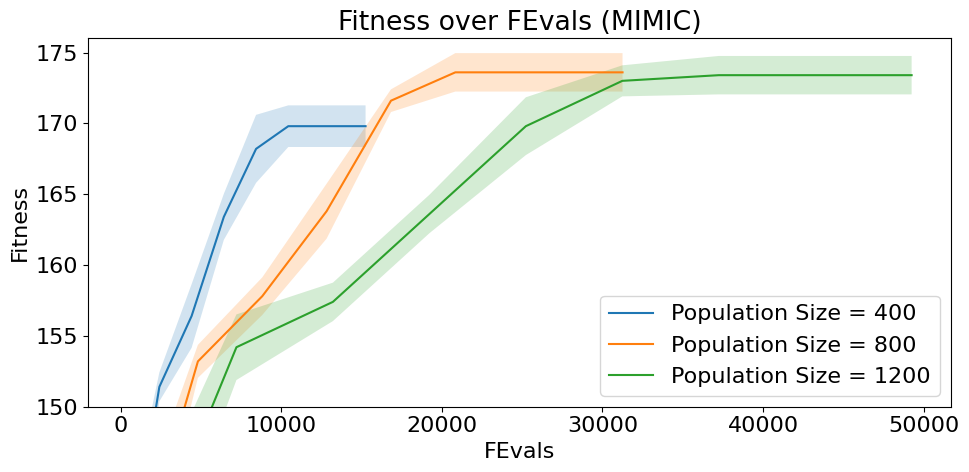

Population Size
Keep Percent = 0.05 Fitness: 168.0 (+/- 3.97994974842648), Time: 7.263127006400009
Keep Percent = 0.1 Fitness: 171.8 (+/- 3.97994974842648), Time: 9.422988509200058
Keep Percent = 0.15 Fitness: 172.6 (+/- 3.97994974842648), Time: 11.191293546799988
Keep Percent = 0.3 Fitness: 173.6 (+/- 3.97994974842648), Time: 12.087636265599986
Keep Percent = 0.5 Fitness: 172.8 (+/- 3.97994974842648), Time: 19.613479713000014


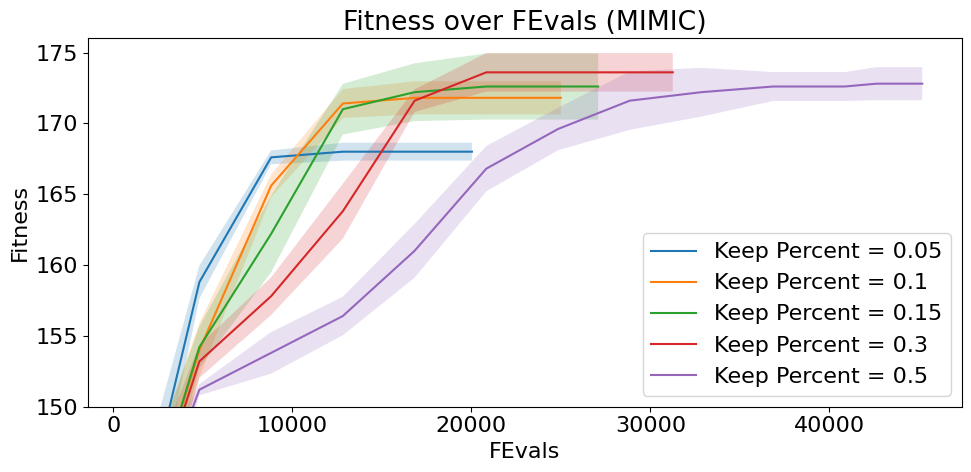

In [27]:
mmc_optimal_HP = get_optimal_hyperparameters(mmc_hp_mean, ['Population Size', 'Keep Percent'])
for key in mmc_optimal_HP.keys():
    plot_fitness_vs_hyperparameter(mmc_hp_mean, mmc_hp_std, mmc_optimal_HP, key, "MIMIC", "KCOLOR", y_lim=(150, 176), show_std=True, x_axis="FEvals")

# 4. MIMIC Superiority

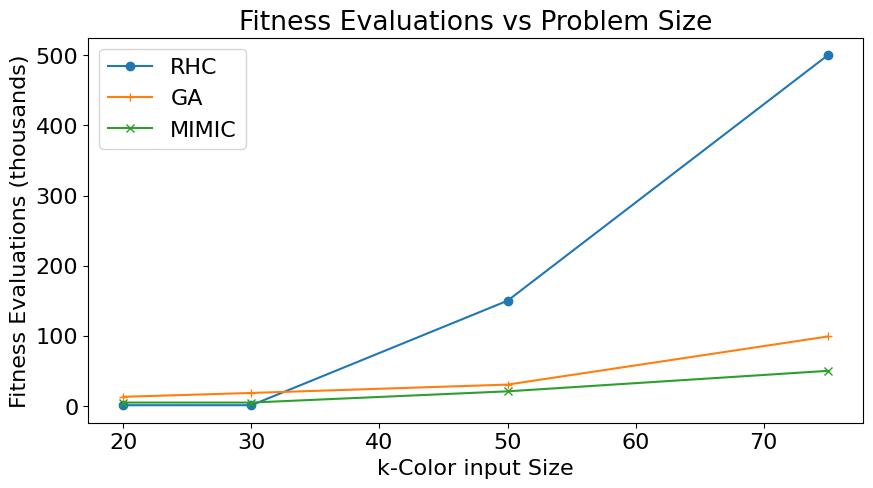

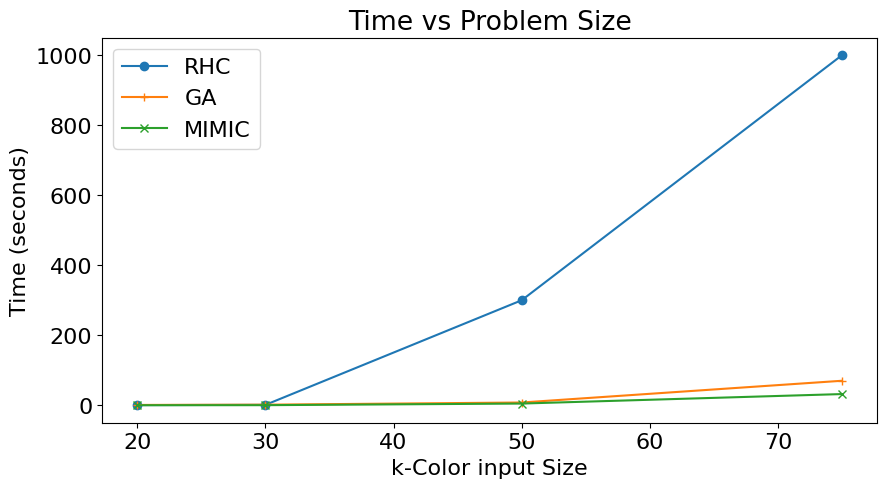

In [84]:
problem_sizes = [20,30,50,75]
RHC = [1,1,150,500]
GA = [13,18.5,30.4, 99]
MIMIC = [4.8, 4.8, 20.8, 50]


plt.figure(figsize=(10, 5))
plt.plot(problem_sizes, RHC,"-o" ,label='RHC')
plt.plot(problem_sizes, GA,"-+" ,label='GA')
plt.plot(problem_sizes, MIMIC,"-x", label='MIMIC')
plt.xlabel('k-Color input Size')
plt.ylabel('Fitness Evaluations (thousands)')
# y log scale
# plt.yscale('log')
plt.legend()
plt.title('Fitness Evaluations vs Problem Size')
plt.savefig('figures/kcolor_fitevals_vs_problem_size.pdf')
plt.show()

problem_sizes = [20,30,50,75]
RHC = [0.5, 1.2, 300, 1000]
GA = [0.95, 1.68, 7.9, 70]
MIMIC = [0.14, 0.29, 4.9, 32]

plt.figure(figsize=(10, 5))
plt.plot(problem_sizes, RHC,"-o" ,label='RHC')
plt.plot(problem_sizes, GA,"-+" ,label='GA')
plt.plot(problem_sizes, MIMIC,"-x", label='MIMIC')
plt.xlabel('k-Color input Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.title('Time vs Problem Size')
plt.savefig('figures/kcolor_time_vs_problem_size.pdf')
plt.show()


